In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.cluster import KMeans

from tensorflow.python.keras import optimizers
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Dropout
from tensorflow.python.keras.utils import plot_model

import pickle

import random
random.seed(123)

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

TRAIN_PCT = .8

data_path = '/home/eharper/data/1_pct_sample_us_handset.csv'

In [2]:
df = pd.read_csv(data_path, low_memory=False, header=0)

In [3]:
df.head()

,main_ConnectionType,main_ConnectionTechnology,main_ServiceProvider,main_ConnectionStart,main_ConnectionEnd,main_CID,main_LAC,main_BSSID,main_MCC,main_MNC,main_Timezone,main_PCI,main_MobileChannel,main_WifiFrequency,main_BSIC,main_Device_Manufacturer,main_Device_Model,main_Device_OS,main_Device_ScreenResolution_Width,main_Device_ScreenResolution_Height,main_Device_Memory,main_Device_Storage,main_Device_DeviceLanguage,main_QOS_QOSDate,main_QOS_UploadThroughput,main_QOS_DownloadThroughput,main_QOS_Latency_Average,main_QOS_LinkSpeed,main_QOS_SignalStrength,main_QOS_Location_Latitude,main_QOS_Location_Longitude,main_QOS_Location_Altitude,main_QOS_Location_HorizontalAccuracy,main_QOS_Location_VerticalAccuracy,main_QOS_Jitter_Average,main_QOS_PacketLoss_LostPercentage,main_QOS_Velocity_Speed,main_QOS_Velocity_Bearing,main_QOS_DeviceFreeMemory,main_QOS_DeviceCPU,main_QOS_DeviceBatteryLevel,main_QOS_DeviceBatteryState,main_QOS_DeviceFreeStorage,main_QOS_DeltaTransmittedBytes,main_QOS_DeltaReceivedBytes,main_QOS_RSRP,main_QOS_RSRQ,main_QOS_RSSNR,main_QOS_CQI,main_QOS_TA,main_QOS_SystemUptime,main_QOS_DeviceUsedStorage,main_QOS_DeviceUsedMemory,main_Country,main_Region,main_City,main_Geohash,conn_Generation_Category,sp_ServiceProviderBrandName
0,MOBILE,LTE,Boost Mobile,2017-07-09 20:15:01 UTC,2017-07-09 20:15:07 UTC,10249,311,NaN,NaN,22423,-18000,58,NaN,NaN,NaN,LGE,LGLS676,ANDROID60,1280,720,1476308992,27031597056,en,2017-07-09 20:15:07 UTC,NaN,NaN,NaN,NaN,NaN,33.9147885,-98.4900346,NaN,29.0,NaN,NaN,NaN,NaN,NaN,418258944,0.69,0.6200000047683716,Charging,7592288256,1224,835,NaN,NaN,NaN,NaN,NaN,1722879,19439308800,1058050048,United States,Texas,Wichita Falls,9y1byvcxzy,4G,NaN
1,MOBILE,LTE,AT&T,2017-07-23 11:44:23 UTC,2017-07-23 11:44:28 UTC,174893826,14125,NaN,310,410,-14400,294,NaN,NaN,NaN,samsung,SM-N920A,ANDROID60,2560,1440,3841765376,25985896448,en,2017-07-23 11:44:28 UTC,NaN,NaN,NaN,NaN,NaN,26.3675186,-80.1715162,NaN,60.0,NaN,NaN,NaN,NaN,NaN,848564224,0.0,0.5899999737739563,Unplugged,17760526336,0,0,NaN,NaN,NaN,NaN,NaN,6064200402,8225370112,2993201152,United States,Florida,NaN,dhwyp8hcum,4G,AT&T
2,MOBILE,LTE,T-Mobile,2017-07-26 02:19:05 UTC,2017-07-26 02:19:23 UTC,17703171,31035,NaN,310,260,-14400,93,NaN,NaN,NaN,samsung,SAMSUNG-SM-G920A,ANDROID60,2560,1440,2809999360,26855358464,es,2017-07-26 02:19:23 UTC,NaN,NaN,NaN,NaN,NaN,18.4338205,-66.475768,NaN,50.0,NaN,NaN,NaN,NaN,NaN,902651904,0.44,0.9700000286102295,Charging,11075596288,2106,6108,NaN,NaN,NaN,NaN,NaN,4699107,15779762176,1907347456,United States,Puerto Rico,Manatí,de28z7cbf3,4G,T-Mobile
3,UNKNOWN,UNKNOWN,NaN,2017-07-08 04:24:02 UTC,2017-07-08 04:34:05 UTC,8546,5,NaN,NaN,4145,-25200,NaN,NaN,NaN,NaN,kyocera,C6730,ANDROID44,960,540,1427030016,5820022784,en,2017-07-08 04:34:05 UTC,NaN,NaN,NaN,NaN,NaN,33.67714619,-116.19211803,-59.0,43.0,NaN,NaN,NaN,NaN,NaN,576475136,0.59,0.9300000071525574,Unplugged,850870272,0,0,NaN,NaN,NaN,NaN,NaN,4545672,4969152512,850554880,United States,California,Coachella,9mvrefxrx7,UNKNOWN,NaN
4,MOBILE,LTE,Boost Mobile,2017-07-30 16:43:02 UTC,2017-07-30 17:15:39 UTC,25981187,21,NaN,312,190,-14400,2,8665,NaN,NaN,LGE,LGLS775,ANDROID70,1280,720,1987317760,10868047872,en,2017-07-30 17:15:39 UTC,NaN,NaN,NaN,NaN,NaN,38.3829114,-81.8024089,NaN,50.0,NaN,NaN,NaN,NaN,NaN,426229760,0.36,0.7900000214576721,Unplugged,2851422208,639549,1379668,NaN,NaN,NaN,NaN,NaN,411973515,8016625664,1561088000,United States,West Virginia,NaN,dnvf6e3k9t,4G,Sprint


In [4]:
df = df[df.main_Device_ScreenResolution_Width != 'main_Device_ScreenResolution_Width']

In [11]:
categorical_vars = ['main_ConnectionType', 'main_ConnectionTechnology', 'main_ServiceProvider', 
                    'main_Device_Manufacturer', 'main_Device_OS', 'main_Device_DeviceLanguage',
                    'main_Region', 'conn_Generation_Category',
                    'sp_ServiceProviderBrandName', 'main_QOS_DeviceBatteryState']

numeric_vars = ['main_Device_ScreenResolution_Width', 'main_Device_ScreenResolution_Height', 'main_Device_Memory',
                'main_Device_Storage', 'main_QOS_Location_Latitude', 'main_QOS_Location_Longitude', 
                'main_QOS_Location_Altitude', 'main_QOS_Location_HorizontalAccuracy', 'main_QOS_Location_VerticalAccuracy',
                'main_QOS_Jitter_Average', 'main_QOS_PacketLoss_LostPercentage', 'main_QOS_Velocity_Speed', 
                'main_QOS_Velocity_Bearing', 'main_QOS_DeviceFreeMemory', 'main_QOS_DeviceCPU', 
                'main_QOS_DeviceBatteryLevel', 'main_QOS_DeviceFreeStorage', 'main_QOS_DeltaTransmittedBytes',
                'main_QOS_DeltaReceivedBytes', 'main_QOS_SystemUptime', 'main_QOS_DeviceUsedStorage', 'main_QOS_DeviceUsedMemory']

In [6]:
for var in categorical_vars:
    df[var] = df[var].astype('category')

In [7]:
for var in numeric_vars:
    df[var] = df[var].astype('float32')

In [9]:
df[categorical_vars].describe()

,main_ConnectionType,main_ConnectionTechnology,main_ServiceProvider,main_Device_Manufacturer,main_Device_Model,main_Device_OS,main_Device_DeviceLanguage,main_Country,main_Region,main_City,main_Geohash,conn_Generation_Category,sp_ServiceProviderBrandName,main_QOS_DeviceBatteryState
count,3412175,3412175,2397757,3412175,3412175,3412175,3411564,3412175,3410641,1894347,3412175,3412175,1910754,3412175
unique,4,14,450,224,2368,26,45,1,53,2141,2571693,4,51,5
top,MOBILE,LTE,Verizon Wireless,samsung,SM-G955U,ANDROID70,en,United States,California,New York,9rb6s3d5s3,4G,T-Mobile,Unplugged
freq,2443896,2057242,636842,2341193,156881,1224357,3202914,3412175,414447,106113,675,2057242,694698,2347917


In [10]:
df[numeric_vars].describe()

,main_Device_ScreenResolution_Width,main_Device_ScreenResolution_Height,main_Device_Memory,main_Device_Storage,main_QOS_Location_Latitude,main_QOS_Location_Longitude,main_QOS_Location_Altitude,main_QOS_Location_HorizontalAccuracy,main_QOS_Location_VerticalAccuracy,main_QOS_Jitter_Average,main_QOS_PacketLoss_LostPercentage,main_QOS_Velocity_Speed,main_QOS_Velocity_Bearing,main_QOS_DeviceFreeMemory,main_QOS_DeviceCPU,main_QOS_DeviceBatteryLevel,main_QOS_DeviceFreeStorage,main_QOS_DeltaTransmittedBytes,main_QOS_DeltaReceivedBytes,main_QOS_SystemUptime,main_QOS_DeviceUsedStorage,main_QOS_DeviceUsedMemory
count,3.354531e+06,3.411988e+06,3.412169e+06,3.378604e+06,3.412175e+06,3.412175e+06,1.524280e+06,3.412170e+06,49238.000000,3.089380e+05,310556.000000,9.714140e+05,1.027673e+06,3.412167e+06,3.381047e+06,3.409030e+06,3.404533e+06,3.411494e+06,3405103.0,3.411564e+06,3.412175e+06,3.412175e+06
mean,1.773338e+03,1.005573e+03,2.469227e+09,3.722925e+10,3.705854e+01,-9.206638e+01,2.018110e+02,3.022828e+02,14.941604,1.585465e+00,1.875684,1.027139e+01,1.809919e+02,6.161818e+08,4.880131e-01,6.556749e-01,2.160945e+10,4.245479e+05,3168563.5,4.554793e+08,2.018850e+10,1.853043e+09
std,5.785427e+02,3.187170e+02,1.030978e+09,3.595467e+10,5.438478e+00,1.664738e+01,3.403875e+02,6.969017e+02,32.120754,5.346424e+00,9.688483,1.191464e+01,1.043236e+02,3.946422e+08,2.746802e-01,2.801934e-01,3.399747e+10,4.582228e+06,26117700.0,1.199486e+10,2.159281e+11,7.520993e+08
min,4.320000e+02,3.200000e+02,3.966689e+08,4.212654e+08,-1.434751e+01,-1.707546e+02,-4.130000e+02,1.000000e-01,-1.000000,1.000000e-06,0.000000,4.650975e-12,9.291363e-04,4.718592e+06,0.000000e+00,0.000000e+00,4.096000e+03,0.000000e+00,0.0,2.408000e+04,0.000000e+00,0.000000e+00
25%,1.280000e+03,7.200000e+02,1.630532e+09,1.265813e+10,3.360981e+01,-9.852895e+01,9.000000e+00,1.900000e+01,4.000000,2.375693e-01,0.000000,7.500000e-01,9.050000e+01,3.063439e+08,2.700000e-01,4.500000e-01,2.151698e+09,8.300000e+01,0.0,4.446791e+07,8.757326e+09,1.225093e+09
50%,1.920000e+03,1.080000e+03,2.007441e+09,2.598590e+10,3.795526e+01,-8.761941e+01,1.260000e+02,2.834100e+01,10.000000,4.384710e-01,0.000000,3.740000e+00,1.800000e+02,5.311283e+08,4.900000e-01,7.000000e-01,9.238774e+09,2.365000e+03,3404.0,1.433854e+08,1.277189e+10,1.695826e+09
75%,2.220000e+03,1.080000e+03,3.536355e+09,5.567317e+10,4.090211e+01,-8.019304e+01,2.400000e+02,9.800000e+01,10.000000,9.022965e-01,0.000000,1.918000e+01,2.700000e+02,8.500429e+08,6.900000e-01,9.000000e-01,2.753679e+10,2.152500e+04,48741.0,3.791545e+08,2.189308e+10,2.500766e+09
max,2.703000e+03,1.600000e+03,8.098845e+09,2.740738e+11,7.132479e+01,1.458140e+02,2.997000e+03,5.000000e+03,1655.842773,1.966445e+02,95.000000,2.733000e+02,3.599981e+02,6.014267e+09,1.000000e+00,1.000000e+00,2.748697e+11,2.683316e+08,536734208.0,1.276501e+12,1.759964e+13,7.432933e+09


In [12]:
categorical_data = pd.get_dummies(df[categorical_vars])

In [14]:
categorical_data.head()

,main_ConnectionType_MOBILE,main_ConnectionType_MOBILEROAMING,main_ConnectionType_UNKNOWN,main_ConnectionType_WIFI,main_ConnectionTechnology_CDMA,main_ConnectionTechnology_EDGE,main_ConnectionTechnology_EHRPD,main_ConnectionTechnology_EVDO0,main_ConnectionTechnology_EVDOA,main_ConnectionTechnology_GPRS,main_ConnectionTechnology_HSDPA,main_ConnectionTechnology_HSPA,main_ConnectionTechnology_HSPAP,main_ConnectionTechnology_HSUPA,main_ConnectionTechnology_LTE,main_ConnectionTechnology_ONEXRTT,main_ConnectionTechnology_UMTS,main_ConnectionTechnology_UNKNOWN,main_ServiceProvider_,main_ServiceProvider_ T-Mobile,main_ServiceProvider_!dea,main_ServiceProvider_123456,main_ServiceProvider_2127,main_ServiceProvider_3,main_ServiceProvider_3 AT,main_ServiceProvider_3 ITA,main_ServiceProvider_31000,main_ServiceProvider_310260,main_ServiceProvider_310410,main_ServiceProvider_311040,main_ServiceProvider_311040 | ROGERS,main_ServiceProvider_311480,main_ServiceProvider_312770,main_ServiceProvider_332127,main_ServiceProvider_33403,main_ServiceProvider_510 09,main_ServiceProvider_854700,main_ServiceProvider_AIRCEL,main_ServiceProvider_AIRTEL,main_ServiceProvider_AIRVOICE WIRELESS,main_ServiceProvider_AIS,main_ServiceProvider_AIS-T,main_ServiceProvider_AIS-T | AIS,main_ServiceProvider_ALGAR TELECOM,main_ServiceProvider_AT T,main_ServiceProvider_AT&T,main_ServiceProvider_AT&T 4G,main_ServiceProvider_AT&T EX,main_ServiceProvider_AT&T MX,main_ServiceProvider_AT&T MicroCell,main_ServiceProvider_AT&T RMZ,main_ServiceProvider_AT&T | AIS,main_ServiceProvider_AT&T | CLARO P.R.,main_ServiceProvider_AT&T | Cellcom,main_ServiceProvider_AT&T | Claro BR,main_ServiceProvider_AT&T | FreedomPop,main_ServiceProvider_AT&T | GOLAN T,main_ServiceProvider_AT&T | Pelephone,main_ServiceProvider_AT&T | ROGERS,main_ServiceProvider_AT&T | Sunrise,main_ServiceProvider_AT&T | Swisscom,main_ServiceProvider_AT&T | T-Mobile NL,main_ServiceProvider_AT&T | TELCEL,main_ServiceProvider_AT&T | TIGO,main_ServiceProvider_AT&T | Telenor,main_ServiceProvider_AT&T | Telenor DK,main_ServiceProvider_Access,main_ServiceProvider_Aircel,main_ServiceProvider_Airtel NG,main_ServiceProvider_Appalachian,main_ServiceProvider_ArmyCell,main_ServiceProvider_Assurance Wireless,main_ServiceProvider_BELL,main_ServiceProvider_BITEL,main_ServiceProvider_BOL MOVIL-E,main_ServiceProvider_BOMOV,main_ServiceProvider_BTC,main_ServiceProvider_BTW,main_ServiceProvider_Beeline,main_ServiceProvider_Bell,main_ServiceProvider_Bitel,main_ServiceProvider_Bluegrass,main_ServiceProvider_Bluegrass Cellular,main_ServiceProvider_Bluegrass Wireless,main_ServiceProvider_Boost,main_ServiceProvider_Boost Mobile,main_ServiceProvider_Bouygues Telecom,main_ServiceProvider_Buscando,main_ServiceProvider_Buscando servicio,main_ServiceProvider_Buscando servicio…,main_ServiceProvider_C Spire,main_ServiceProvider_CAN Rogers Wireless Inc.,main_ServiceProvider_CC,main_ServiceProvider_CC MicroCell,main_ServiceProvider_CC Network,main_ServiceProvider_CELLONE,main_ServiceProvider_CLARO,main_ServiceProvider_CLARO BR,main_ServiceProvider_CLARO BR 51,main_ServiceProvider_CLARO P.R.,main_ServiceProvider_CREDO Mobile,main_ServiceProvider_Carolina West,main_ServiceProvider_Carrier,main_ServiceProvider_Cell,main_ServiceProvider_Cell One,main_ServiceProvider_Cell One of NE Colorado,main_ServiceProvider_Cell One of NE Colorado | ROGERS,main_ServiceProvider_Cellcom,main_ServiceProvider_Cellular ONE,main_ServiceProvider_Cellular One,main_ServiceProvider_CellularONE,main_ServiceProvider_Chameleon,main_ServiceProvider_Chariton,main_ServiceProvider_Choice Wireless,main_ServiceProvider_Claro,main_ServiceProvider_Claro AR,main_ServiceProvider_Claro BR,main_ServiceProvider_Claro PR,main_ServiceProvider_Claro Puerto Rico,main_ServiceProvider_Comviq,main_ServiceProvider_DIGICEL,main_ServiceProvider_DIGITEL,main_ServiceProvider_DOCOMO PACIFIC,main_ServiceProvider_DOCOMO PACIFIC | DPAC,main_ServiceProvider_DPAC,main_ServiceProvider_DTAC,main_ServiceProvider_Def

In [52]:
# fill na with zeros on numeric data
numeric_data = df[numeric_vars].fillna(value=0)

In [53]:
# Normalize the testing and training data using the MinMaxScaler from the scikit learn package
scaler = MinMaxScaler()

# Make sure to only fit the scaler on the training data
scaled_numerics = scaler.fit_transform(numeric_data)

scaled_numerics = scaled_numerics.astype(np.float32)

In [54]:
scaled_numerics.shape

(3412175, 22)

In [55]:
categorical_data.shape

(3412175, 876)

In [56]:
X = np.concatenate([scaled_numerics, categorical_data.values], axis=1)

In [57]:
X

array([[0.4735479 , 0.45      , 0.18228637, ..., 0.        , 0.        ,
        0.        ],
       [0.9470958 , 0.9       , 0.4743597 , ..., 0.        , 0.        ,
        1.        ],
       [0.9470958 , 0.9       , 0.346963  , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.71032184, 0.675     , 0.36689162, ..., 0.        , 0.        ,
        1.        ],
       [0.4735479 , 0.45      , 0.20456572, ..., 0.        , 0.        ,
        1.        ],
       [0.71032184, 0.675     , 0.47421858, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [58]:
train_size = int(X.shape[0] * TRAIN_PCT)
train_indices = np.random.choice(range(0, X.shape[0]), size=train_size, replace=False)
train_mask = np.zeros(X.shape[0], dtype=bool)
train_mask[train_indices] = True

In [59]:
X_train = X[train_mask]
X_test = X[~train_mask]

In [60]:
input_dim = X_train.shape[1]

# model hyperparameters
batch_size = 512

latent_dim = 4 

max_epochs = 10 

In [61]:
# The encoder will consists of a number of dense layers that decrease in size 
# as we taper down towards the bottleneck of the network, the latent space
input_data = Input(shape=(input_dim,), name='encoder_input')

# hidden layers
encoder = Dense(96,activation='tanh', name='encoder_1')(input_data)
encoder = Dropout(.1)(encoder)
encoder = Dense(64,activation='tanh', name='encoder_2')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(48,activation='tanh', name='encoder_3')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(16,activation='tanh', name='encoder_4')(encoder)
encoder = Dropout(.1)(encoder)

# bottleneck layer
latent_encoding = Dense(latent_dim, activation='linear', name='latent_encoding')(encoder)

In [62]:
encoder_model = Model(input_data, latent_encoding)

encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 898)               0         
_________________________________________________________________
encoder_1 (Dense)            (None, 96)                86304     
_________________________________________________________________
dropout_8 (Dropout)          (None, 96)                0         
_________________________________________________________________
encoder_2 (Dense)            (None, 64)                6208      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
encoder_3 (Dense)            (None, 48)                3120      
_________________________________________________________________
dropout_10 (Dropout)         (None, 48)                0         
__________

In [63]:
# The decoder network is a mirror image of the encoder network
decoder = Dense(16, activation='tanh', name='decoder_1')(latent_encoding)
decoder = Dropout(.1)(decoder)
decoder = Dense(48, activation='tanh', name='decoder_2')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(64, activation='tanh', name='decoder_3')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(96, activation='tanh', name='decoder_4')(decoder)
decoder = Dropout(.1)(decoder)

# The output is the same dimension as the input data we are reconstructing
reconstructed_data = Dense(input_dim, activation='linear', name='reconstructed_data')(decoder)

In [64]:
autoencoder_model = Model(input_data, reconstructed_data)

autoencoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 898)               0         
_________________________________________________________________
encoder_1 (Dense)            (None, 96)                86304     
_________________________________________________________________
dropout_8 (Dropout)          (None, 96)                0         
_________________________________________________________________
encoder_2 (Dense)            (None, 64)                6208      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
encoder_3 (Dense)            (None, 48)                3120      
_________________________________________________________________
dropout_10 (Dropout)         (None, 48)                0         
__________

In [65]:
opt = optimizers.Adam(lr=.00001)

autoencoder_model.compile(optimizer=opt, loss='mse')

In [66]:
train_history = autoencoder_model.fit(X_train, X_train,
        shuffle=True,
        epochs=max_epochs,
        batch_size=batch_size,
        validation_data=(X_test, X_test))

Train on 2729740 samples, validate on 682435 samples
Epoch 1/10
2729740/2729740 [==============================] - 76s 28us/sample - loss: 0.0079 - val_loss: 0.0046
Epoch 2/10
2729740/2729740 [==============================] - 76s 28us/sample - loss: 0.0047 - val_loss: 0.0040
Epoch 3/10
2729740/2729740 [==============================] - 76s 28us/sample - loss: 0.0043 - val_loss: 0.0040
Epoch 4/10
2729740/2729740 [==============================] - 76s 28us/sample - loss: 0.0043 - val_loss: 0.0040
Epoch 5/10
2729740/2729740 [==============================] - 76s 28us/sample - loss: 0.0042 - val_loss: 0.0040
Epoch 6/10
2729740/2729740 [==============================] - 76s 28us/sample - loss: 0.0042 - val_loss: 0.0040
Epoch 7/10
2729740/2729740 [==============================] - 76s 28us/sample - loss: 0.0042 - val_loss: 0.0040
Epoch 8/10
2729740/2729740 [==============================] - 75s 28us/sample - loss: 0.0042 - val_loss: 0.0039
Epoch 9/10
2729740/2729740 [=======================

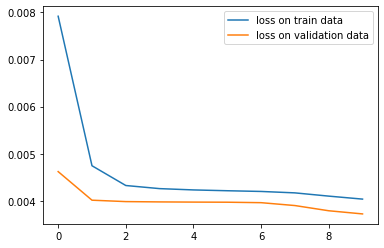

In [67]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(['loss on train data', 'loss on validation data'])

In [68]:
# Reconstruct the data using our trainined autoencoder model.
X_test_recon = autoencoder_model.predict(X_test)

# the reconstruction score is the mean of the reconstruction errors (relatively high scores are anomalous)
reconstruction_scores = np.mean((X_test - X_test_recon)**2, axis=1)

In [69]:
# store the reconstruction data in a Pandas dataframe
anomaly_data = pd.DataFrame({'recon_score':reconstruction_scores})

# if our reconstruction scores our normally distributed we can use their statistics
anomaly_data.describe()

,recon_score
count,682435.000000
mean,0.003722
std,0.001357
min,0.000400
25%,0.002771
50%,0.003529
75%,0.004496
max,0.014526


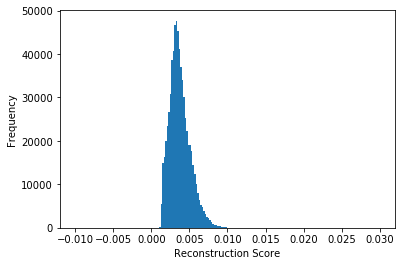

In [70]:
# plotting the density will give us an idea of how the reconstruction scores are distributed
plt.xlabel('Reconstruction Score')
anomaly_data['recon_score'].plot.hist(bins=200, range=[-.01, .03])